In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# N: Normal beat

# S: Supraventricular premature beat

# V: Premature ventricular contraction

# F: Fusion of ventricular and normal beat

# Q: Unclassifiable beat

# M: myocardial infarction


# train set


In [3]:
%%time
dir = Path('Data/Original/train')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

CPU times: total: 2 s
Wall time: 2.08 s


,Filepath,Label
0,Data\Original\train\F\F1.png,F
1,Data\Original\train\F\F10.png,F
2,Data\Original\train\F\F100.png,F
3,Data\Original\train\F\F101.png,F
4,Data\Original\train\F\F102.png,F
...,...,...
99194,Data\Original\train\V\V995.png,V
99195,Data\Original\train\V\V996.png,V
99196,Data\Original\train\V\V997.png,V
99197,Data\Original\train\V\V998.png,V


In [4]:
dataframe["Label"].value_counts()

Label
N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: count, dtype: int64

In [5]:
samples = []
for category in ["N", "M", "Q", "V", "S", "F"]:
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(642, random_state=1))

dataframe_train = (
    pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
)
dataframe_train["Label"].value_counts()

Label
S    642
N    642
V    642
M    642
Q    642
F    642
Name: count, dtype: int64

# test set


In [6]:
%%time
dir = Path('Data/Original/test')

filepaths = list(dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)

CPU times: total: 547 ms
Wall time: 632 ms


In [7]:
dataframe_test["Label"].value_counts()

Label
N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: count, dtype: int64

In [8]:
samples = []
for category in ["N", "M", "Q", "V", "S", "F"]:
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(161, random_state=1))

dataframe_test = (
    pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
)
dataframe_test["Label"].value_counts()

Label
M    161
F    161
Q    161
V    161
N    161
S    161
Name: count, dtype: int64

# Image generators


In [9]:
def gray_torgb(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image, image, image))
    return image

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb, rescale=1.0 / 255, validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb, rescale=1.0 / 255
)

In [11]:
size = 224
color_mode = "rgb"
batch_size = 32

train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col="Filepath",
    y_col="Label",
    target_size=(size, size),
    color_mode=color_mode,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset="training",
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col="Filepath",
    y_col="Label",
    target_size=(size, size),
    color_mode=color_mode,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset="validation",
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col="Filepath",
    y_col="Label",
    target_size=(size, size),
    color_mode=color_mode,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

Found 3082 validated image filenames belonging to 6 classes.
Found 770 validated image filenames belonging to 6 classes.
Found 966 validated image filenames belonging to 6 classes.


In [12]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

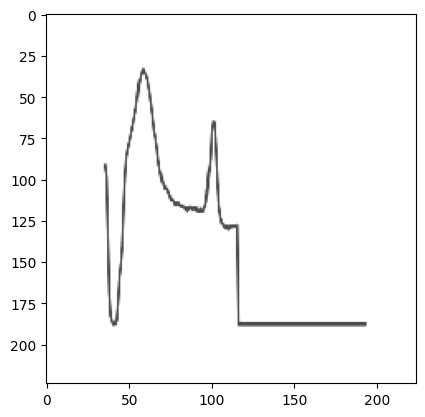

In [50]:
plt.imshow(test_images[0][0][3])

# Modeling


In [51]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, Xception, InceptionV3


pretrained_vgg16_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="avg")
pretrained_vgg19_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="avg")
pretrained_resnet_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="avg")
pretrained_xception_model = Xception(input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="avg")
pretrained_inception_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="avg")

pretrained_vgg16_model.trainable = False
pretrained_vgg19_model.trainable = False
pretrained_resnet_model.trainable = False
pretrained_xception_model.trainable = False
pretrained_inception_model.trainable = False

In [52]:
def make_model(pretrained_model, preprocess_fun):
    return Sequential(
        [
            Lambda(preprocess_fun),  # Preprocess input using Lambda layer
            pretrained_model,
            Flatten(),
            Dropout(0.2),
            Dense(512, activation="relu"),
            Dense(128, activation="relu"),
            Dense(6, activation="softmax"),
        ]
    )

In [53]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *


models = {
    "VGG16": make_model(pretrained_vgg16_model, tf.keras.applications.vgg16.preprocess_input),
    "VGG19": make_model(pretrained_vgg19_model, tf.keras.applications.vgg19.preprocess_input),
    "ResNet": make_model(pretrained_resnet_model, tf.keras.applications.resnet.preprocess_input),
    'Xception': make_model(pretrained_xception_model, tf.keras.applications.xception.preprocess_input),
    'Inception': make_model(pretrained_inception_model, tf.keras.applications.inception_v3.preprocess_input)
}

model_histories = {}

In [54]:
%%time
import keras
num_epochs = 50

for name, model in models.items():
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            tf.keras.metrics.AUC(
                num_thresholds=200,
                curve="ROC",
                summation_method="interpolation",
                multi_label=False,
            ),
        ],
    )

    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=f"Saved Models 3/{name}.h5",
        save_weights_only=False,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
)

    result=model.fit(
        train_images,
        steps_per_epoch=3072//32,
        validation_data=val_images,
        validation_steps=768//32,
        epochs=num_epochs,
        callbacks=[checkpoint, reduce_lr]
    )

    model_histories[name] = result
   

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 1.6479 - accuracy: 0.2843 - precision: 0.6774 - recall: 0.0344 - auc_1: 0.6716
Epoch 1: val_accuracy improved from -inf to 0.58594, saving model to Saved Models 3\VGG16.h5
96/96 [==============================] - 23s 235ms/step - loss: 1.6479 - accuracy: 0.2843 - precision: 0.6774 - recall: 0.0344 - auc_1: 0.6716 - val_loss: 1.3166 - val_accuracy: 0.5859 - val_precision: 0.9487 - val_recall: 0.0964 - val_auc_1: 0.8425 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 1.3066 - accuracy: 0.3807 - precision: 0.6457 - recall: 0.1416 - auc_1: 0.8052
Epoch 2: val_accuracy did not improve from 0.58594
96/96 [==============================] - 22s 228ms/step - loss: 1.3066 - accuracy: 0.3807 - precision: 0.6457 - recall: 0.1416 - auc_1: 0.8052 - val_loss: 1.1406 - val_accuracy: 0.5482 - val_precision: 0.6617 - val_recall: 0.1732 - val_auc_1: 0.8712 - lr: 0.0010
Epoch 3/50
96/96 [==================

# Result


In [38]:
from keras.models import load_model
models = {}

for saved_model_name in os.listdir('Saved Models 2'):
    models[saved_model_name.split('.')[0]] = load_model(f'Saved Models/{saved_model_name}')

In [ ]:
for name, model in models.items():
    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    results = model.evaluate(test_images)

    print("     Test Loss: {:.4f}".format(results[0]))
    print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
    print("Test Precision: {:.4f}%".format(results[2] * 100))
    print("   Test Recall: {:.4f}%".format(results[3] * 100))
    print("      Test AUC: {:.4f}".format(results[4]))


Inception Model Results:
31/31 [==============================] - 28s 141ms/step - loss: 0.4533 - accuracy: 0.9058 - precision: 0.9085 - recall: 0.9048 - auc_4: 0.9764
     Test Loss: 0.4533
 Test Accuracy: 90.5797%
Test Precision: 90.8524%
   Test Recall: 90.4762%
      Test AUC: 0.9764
Resnet Model Results:
31/31 [==============================] - 8s 173ms/step - loss: 0.1099 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc_2: 0.9978
     Test Loss: 0.1099
 Test Accuracy: 96.1698%
Test Precision: 96.1698%
   Test Recall: 96.1698%
      Test AUC: 0.9978
VGG16 Model Results:
31/31 [==============================] - 16s 266ms/step - loss: 0.1650 - accuracy: 0.9472 - precision: 0.9549 - recall: 0.9420 - auc: 0.9970
     Test Loss: 0.1650
 Test Accuracy: 94.7205%
Test Precision: 95.4879%
   Test Recall: 94.2029%
      Test AUC: 0.9970
VGG19 Model Results:
31/31 [==============================] - 7s 227ms/step - loss: 0.1966 - accuracy: 0.9327 - precision: 0.9420 - recall: 0.9

In [ ]:
for name, model in models.items():
    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    results = model.evaluate(test_images)

    print("     Test Loss: {:.4f}".format(results[0]))
    print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
    print("Test Precision: {:.4f}%".format(results[2] * 100))
    print("   Test Recall: {:.4f}%".format(results[3] * 100))
    print("      Test AUC: {:.4f}".format(results[4]))


Inception Model Results:
31/31 [==============================] - 6s 129ms/step - loss: 0.3110 - accuracy: 0.9037 - precision: 0.9100 - recall: 0.9006 - auc_4: 0.9885
     Test Loss: 0.3110
 Test Accuracy: 90.3727%
Test Precision: 91.0042%
   Test Recall: 90.0621%
      Test AUC: 0.9885
ResNet Model Results:
31/31 [==============================] - 6s 166ms/step - loss: 0.1153 - accuracy: 0.9565 - precision: 0.9565 - recall: 0.9565 - auc_2: 0.9977
     Test Loss: 0.1153
 Test Accuracy: 95.6522%
Test Precision: 95.6522%
   Test Recall: 95.6522%
      Test AUC: 0.9977
VGG16 Model Results:
31/31 [==============================] - 8s 250ms/step - loss: 0.1470 - accuracy: 0.9513 - precision: 0.9591 - recall: 0.9462 - auc: 0.9975
     Test Loss: 0.1470
 Test Accuracy: 95.1346%
Test Precision: 95.9077%
   Test Recall: 94.6170%
      Test AUC: 0.9975
VGG19 Model Results:
31/31 [==============================] - 7s 212ms/step - loss: 0.1882 - accuracy: 0.9348 - precision: 0.9453 - recall: 0.929

In [13]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.savefig(f'Performance Graphs/{name}_training_history.png')
    plt.show()

In [14]:
for model, history in model_histories.items():
    plot_model_performance(model, history)

NameError: name 'model_histories' is not defined

In [50]:
y_pred = models['VGG19'].predict(test_images)

31/31 [==============================] - 7s 215ms/step


In [51]:
y_pred = np.argmax(y_pred, axis=1)

# classification report & confusion matrix


# ploting the confusion matrix


Text(0.5, 1.0, 'VGG19 Confusion Matrix')

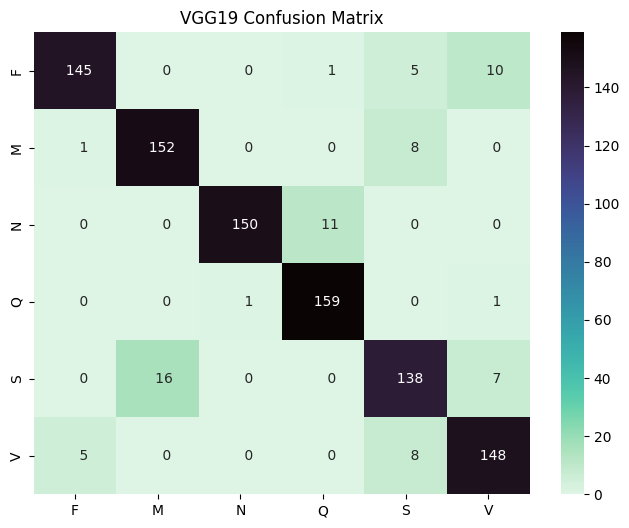

In [54]:
import seaborn as sns

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_images.labels, y_pred)

plt.figure(figsize=(8, 6))
classes = ["F", "M", "N", "Q", "S", "V"]
ax = sns.heatmap(cm, annot=cm, cmap="mako_r", fmt="5d")
ax.set_yticklabels(classes)
ax.set_xticklabels(classes)
ax.set_title('VGG19 Confusion Matrix')